 **Part 1 Data Preprocessing and Feature Importance**

In [24]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Assignment 3/CustomerChurn_dataset.csv")
df = pd.DataFrame(data)
df

In [26]:
#Dropping 'CustomerID'
df = df.drop('customerID',axis=1)

In [27]:
# converting the "TotalCharged" column from object to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [28]:
# separating columns into numeric columns and object columns to make encoding effective
numeric_columns = []
object_columns = []

for i in df.columns:
    if df[i].dtype == "object" or i == 'SeniorCitizen':
        object_columns.append(i)
    else:
        numeric_columns.append(i)

# Create a new DataFrame containing the object columns
object_df = df[object_columns]

# Create a new DataFrame containing the numeric columns
numeric_df = df[numeric_columns]

# finding the minimum and maximum values of the numeric columns to help in setting value restrictions for the user later in the deployed model
numeric_range = numeric_df.describe().loc[['min', 'max']]

# Print the range of values for each column
print("Range of Values for Each Column:")
print(numeric_range)


Range of Values for Each Column:
     tenure  MonthlyCharges  TotalCharges
min     0.0           18.25          18.8
max    72.0          118.75        8684.8


In [29]:
# imputing missing values in the numeric_df
from sklearn.impute import SimpleImputer

# Create the SimpleImputer
imputer = SimpleImputer(strategy='mean')

imputer.fit(numeric_df)

# Fit and transform the imputer on the numeric DataFrame
imputed_values = imputer.fit_transform(numeric_df)

# Create a new DataFrame with the imputed values and original column names
numeric_df = pd.DataFrame(imputed_values, columns=numeric_df.columns)

# Check the info of the imputed DataFrame
numeric_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   float64
 1   MonthlyCharges  7043 non-null   float64
 2   TotalCharges    7043 non-null   float64
dtypes: float64(3)
memory usage: 165.2 KB


In [ ]:
# Label encoding of object_df
from sklearn.preprocessing import LabelEncoder



# a dictionary to store all the distinct values in a columns and what they were encoded to
distinct_entries_dict = {}

# encoding
for column in object_df.columns:
    label = LabelEncoder()
    encoded_column = label.fit_transform(object_df[column])
    object_df[column] = encoded_column

    # Get the distinct entries for the current column
    distinct_entries = list(label.classes_)

    # Store the distinct entries and their encoding in the dictionary
    distinct_entries_dict[column] = {
        'distinct_entries': distinct_entries,
        'encoding_mapping': dict(zip(distinct_entries, label.transform(distinct_entries)))
    }



# Print the dictionary with distinct entries and their encoding for each column
print("Distinct Entries and Encoding for Each Column:")
for column, entry_info in distinct_entries_dict.items():
    distinct_entries = entry_info['distinct_entries']
    encoding_mapping = entry_info['encoding_mapping']

    print(f"{column}:")
    print(f"  Distinct Entries: {distinct_entries}")
    print(f"  Encoding Mapping: {encoding_mapping}")
    print()



In [31]:
# Joining the processed dataframes into one
frames = [object_df, numeric_df]

new_dataframe = pd.concat(frames, axis=1, join='inner')

new_dataframe

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,1.0,29.85,29.85
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,34.0,56.95,1889.50
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,2.0,53.85,108.15
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,45.0,42.30,1840.75
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,2.0,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,1,2,0,2,0,2,2,2,2,1,1,3,0,24.0,84.80,1990.50
7039,0,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1,0,72.0,103.20,7362.90
7040,0,0,1,1,0,1,0,2,0,0,0,0,0,0,1,2,0,11.0,29.60,346.45
7041,1,1,1,0,1,2,1,0,0,0,0,0,0,0,1,3,1,4.0,74.40,306.60


**Feature Extraction**

In [32]:
y = new_dataframe['Churn']
x = new_dataframe.drop(['Churn'], axis=1)


In [33]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt



# Initialize the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to your data
clf.fit(x,y)

# Get feature importances
feature_importances = clf.feature_importances_

# Get the names of the features
feature_names = x.columns  # If you have a DataFrame with column names

# Create a DataFrame to display the feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
N = 10  # Change this to the number of features you want to display
top_features = feature_importance_df.head(10)
print(top_features)



            Feature  Importance
18     TotalCharges    0.190395
17   MonthlyCharges    0.178416
16           tenure    0.157880
13         Contract    0.081140
7    OnlineSecurity    0.052433
15    PaymentMethod    0.050774
10      TechSupport    0.032502
0            gender    0.028730
6   InternetService    0.028103
8      OnlineBackup    0.026643


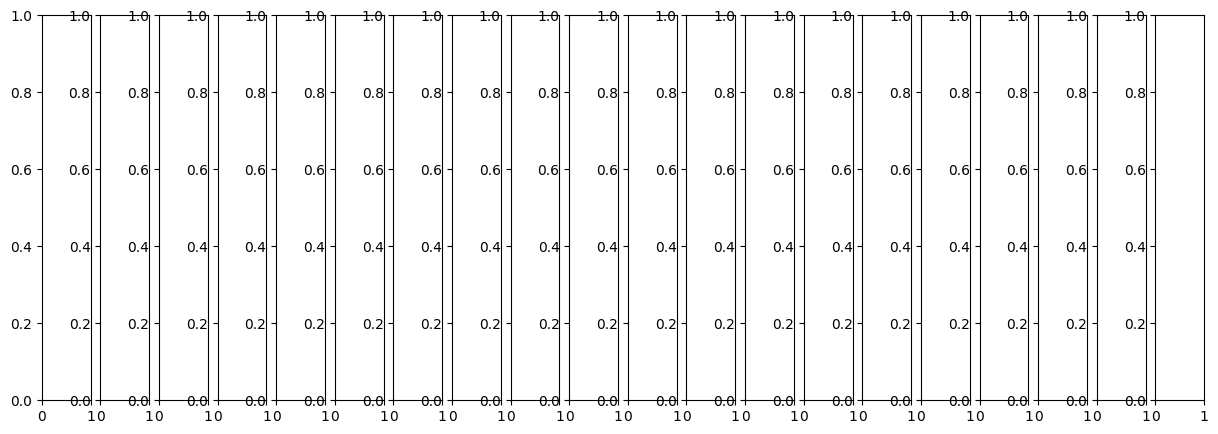

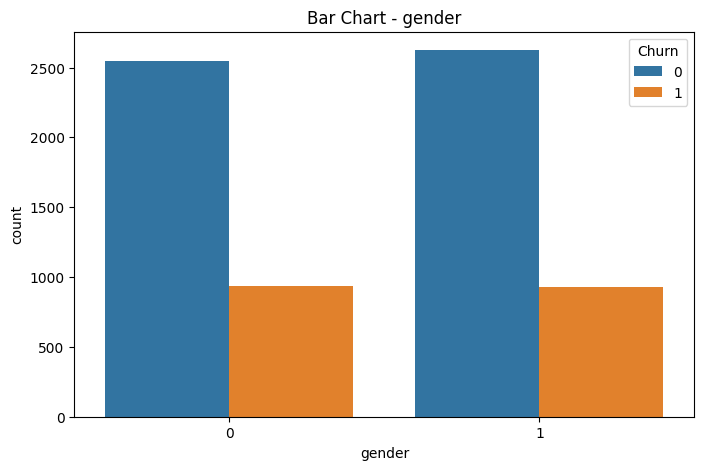

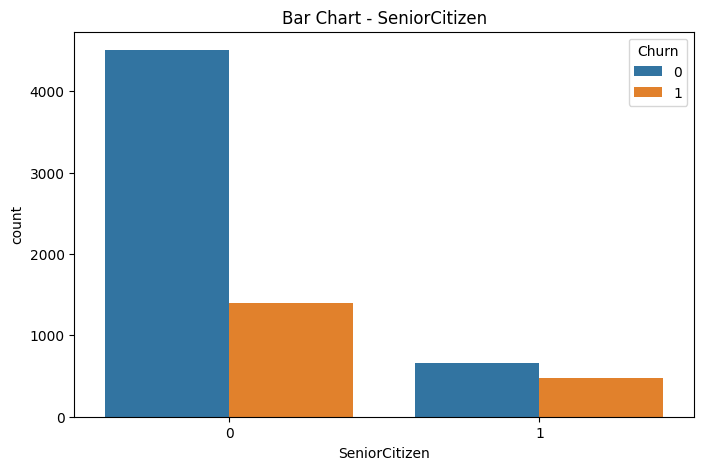

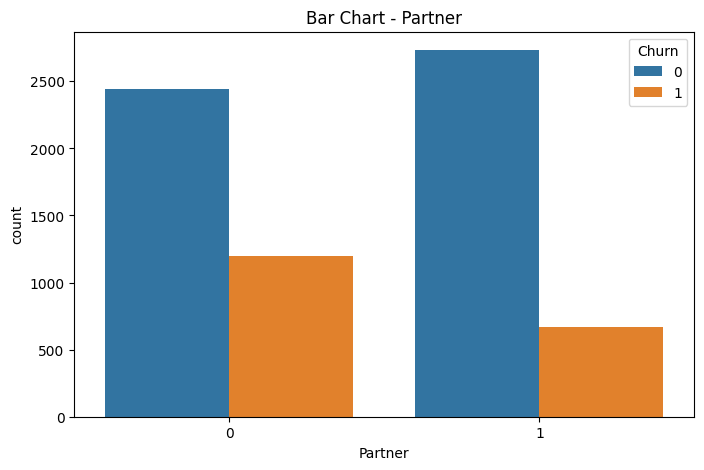

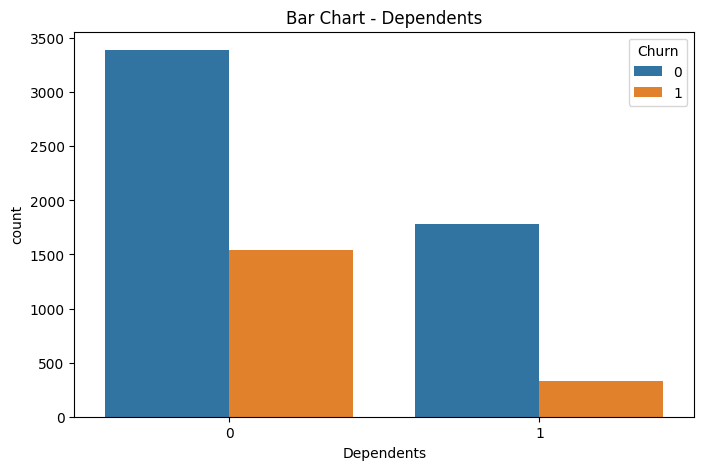

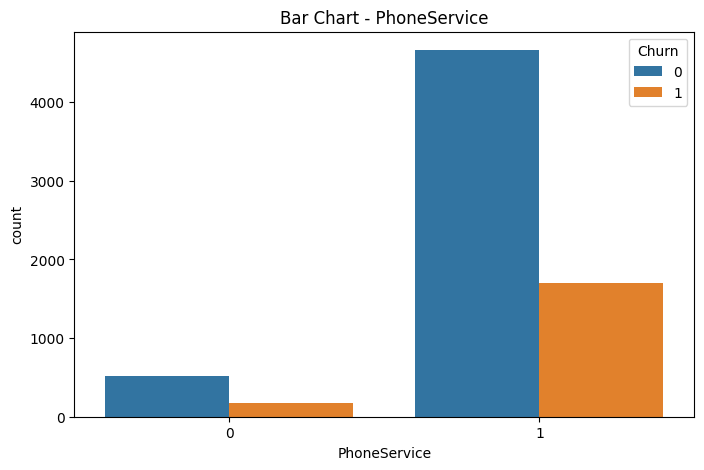

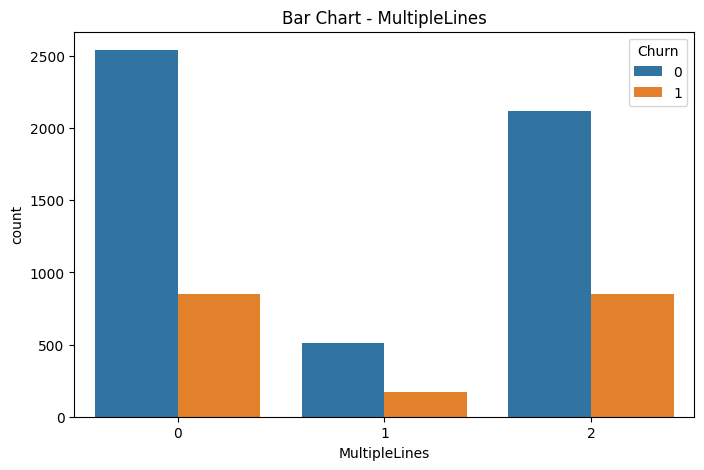

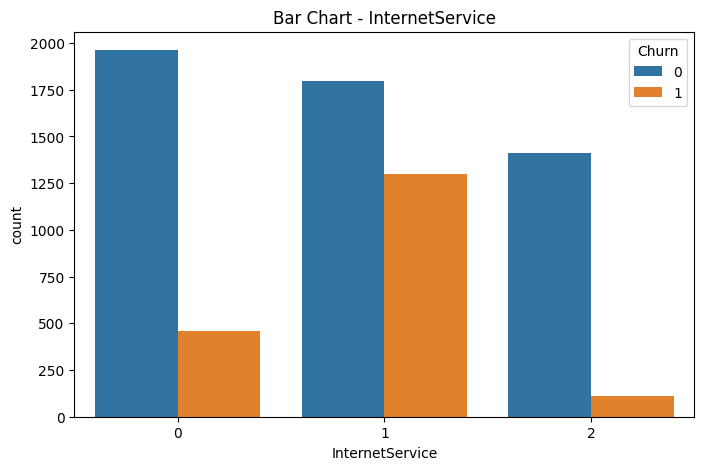

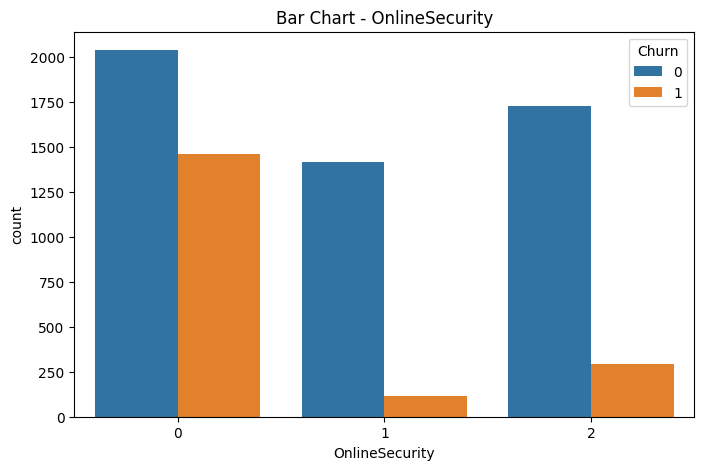

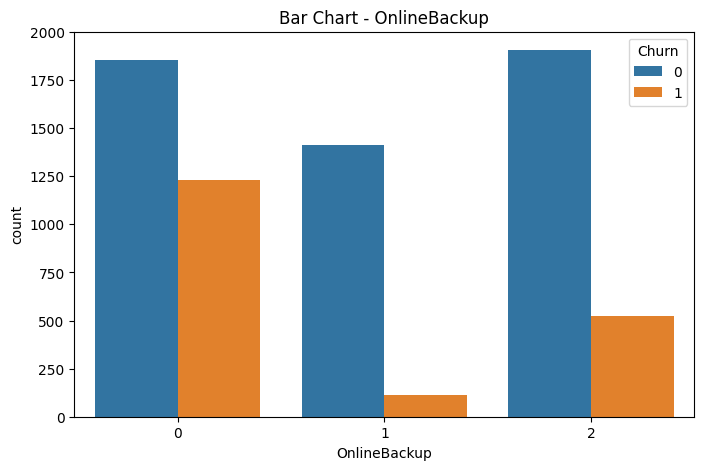

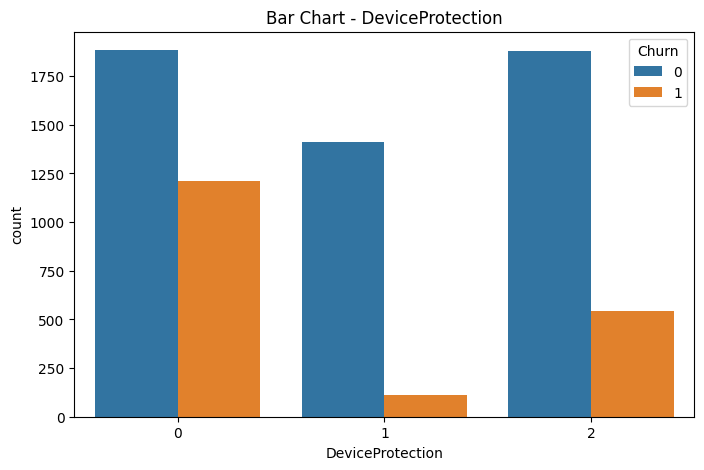

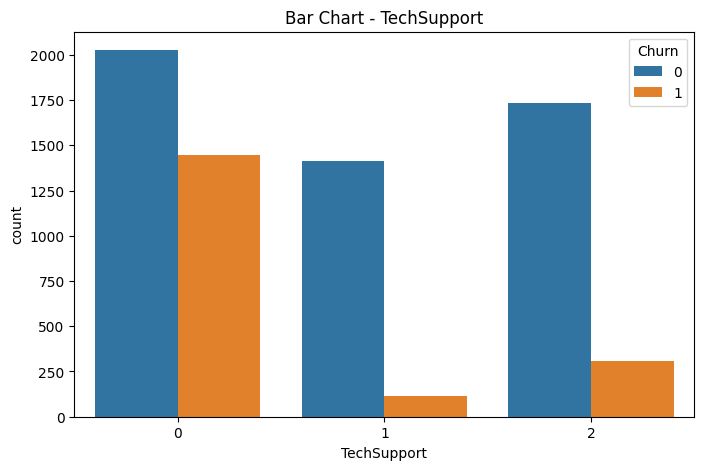

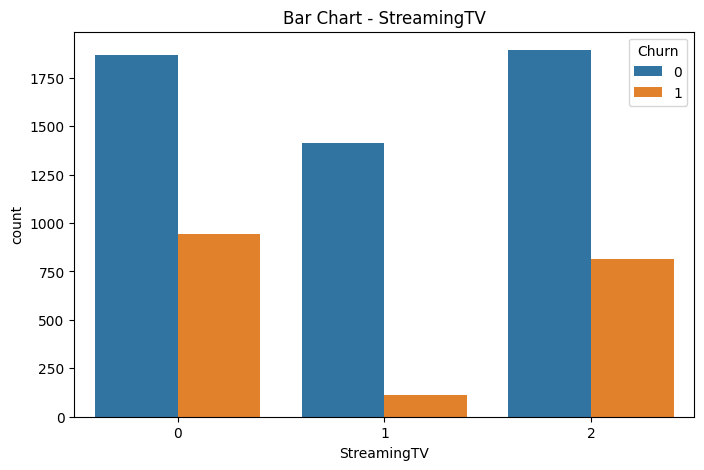

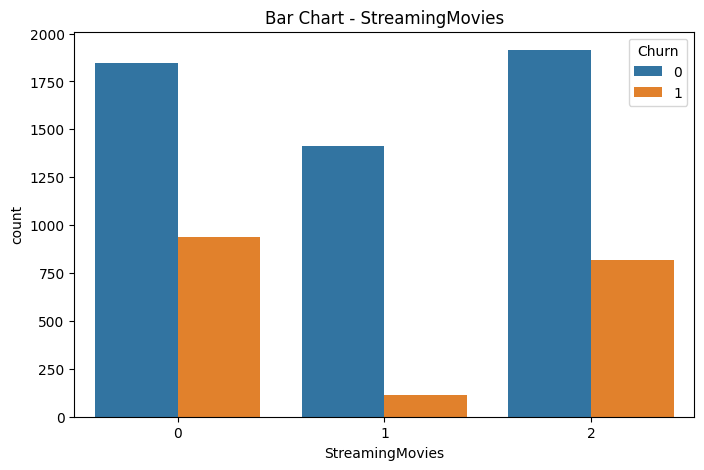

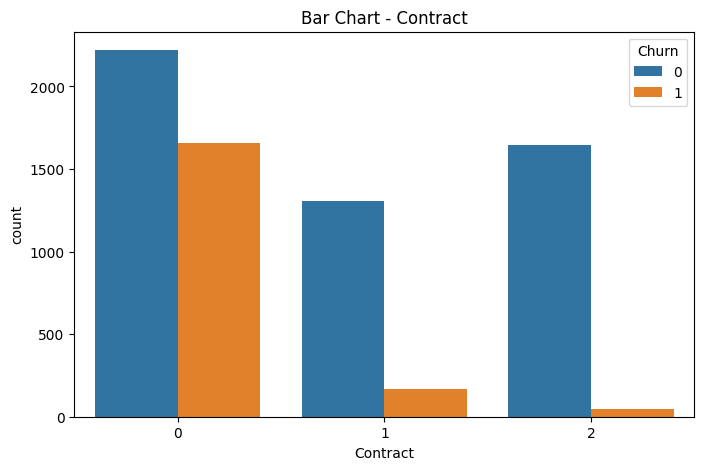

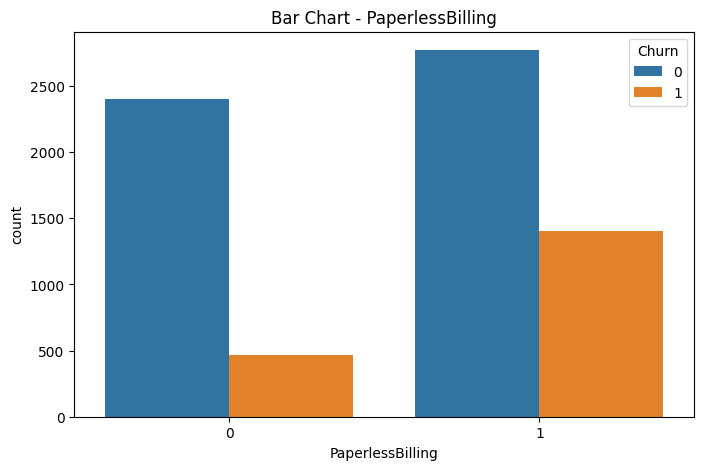

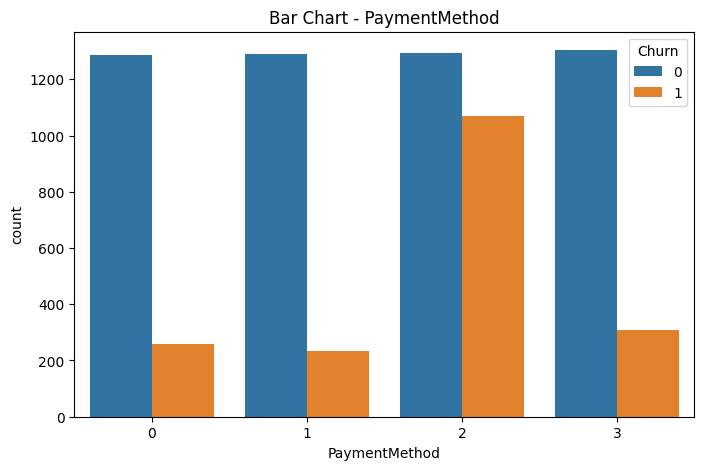

<Figure size 800x500 with 0 Axes>

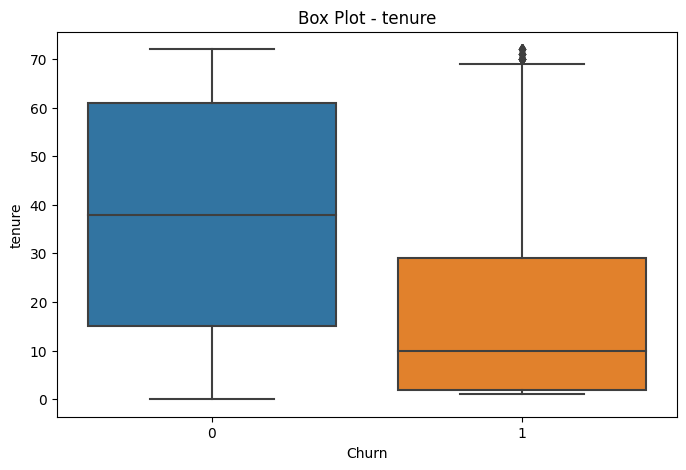

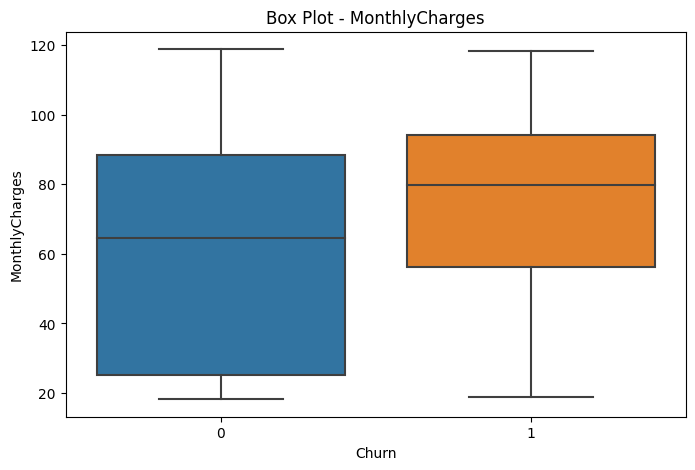

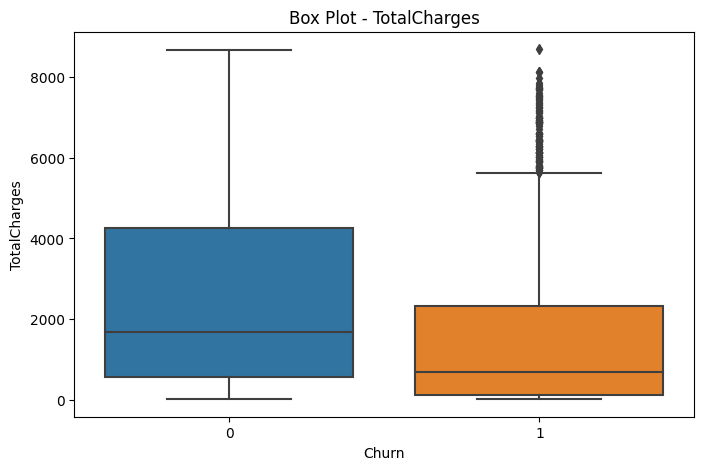

In [52]:
# Using the top 10 features which are important to the Churning og customers
important_features = ['TotalCharges','MonthlyCharges','tenure','Contract','PaymentMethod','TechSupport','OnlineSecurity','gender','InternetService','OnlineBackup']


#  ---------------------------- EDA ------------------------------#
import matplotlib.pyplot as plt
import seaborn as sns




# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=len(new_dataframe.columns), figsize=(15, 5))

# Iterate through important_features and create box plots or bar charts accordingly
for i, feature in enumerate(new_dataframe.columns):
    plt.figure(figsize=(8, 5))

    if feature in ['TotalCharges', 'MonthlyCharges', 'tenure']:
        # Box plot for specific columns
        sns.boxplot(x='Churn', y=feature, data=new_dataframe)
        plt.title(f'Box Plot - {feature}')
    elif feature == 'Churn':
      pass
    else:
        # Bar chart for other columns
        sns.countplot(x=feature, hue='Churn', data=new_dataframe)
        plt.title(f'Bar Chart - {feature}')

    plt.show()






In [35]:
# --------------------------- SCALING -------------------------------------#
# The reason for doing the scaling here is make sure the scaler object is fit with the same number of features that will  be requested from the user(important_features)
import pickle
from sklearn.preprocessing import StandardScaler
X = x[important_features] # uisng the best 10 features form the feature importance method
y = y
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_data, columns=X.columns)
X = scaled_df
X

# Saving the Scaler object to a file using pickle
scaler_filename = '/content/drive/My Drive/Assignment 3/scaler.pkl'
pickle.dump(scaler, open(scaler_filename, 'wb'))


**Part 2: Multi-Layer Perceptron Model Using Functional API**

In [36]:
# Splitting
from sklearn.model_selection import train_test_split


Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.1, random_state=42)
Xtrain, xval, Ytrain, yval = train_test_split(Xtrain, Ytrain, test_size=0.1, random_state=42)


In [45]:
# ------------------------------------ MLP --------------------------------------------#
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from keras.optimizers import Adam

# Define the Keras Functional API model

input_layer = Input(shape=(10,))

hidden_layer1 = Dense(32, activation='relu')(input_layer)
hidden_layer2 = Dense(64, activation='relu')(hidden_layer1)
hidden_layer3 = Dense(64, activation='relu')(hidden_layer2)

output_layer = Dense(1, activation='sigmoid')(hidden_layer3)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(Xtrain, Ytrain, epochs=50, batch_size=32, validation_data=(xval, yval))



Epoch 1/50
179/179 [==============================] - 2s 5ms/step - loss: 0.5910 - accuracy: 0.6885 - val_loss: 0.5132 - val_accuracy: 0.7445
Epoch 2/50
179/179 [==============================] - 1s 4ms/step - loss: 0.4966 - accuracy: 0.7509 - val_loss: 0.4724 - val_accuracy: 0.7744
Epoch 3/50
179/179 [==============================] - 1s 5ms/step - loss: 0.4673 - accuracy: 0.7747 - val_loss: 0.4539 - val_accuracy: 0.7760
Epoch 4/50
179/179 [==============================] - 1s 3ms/step - loss: 0.4522 - accuracy: 0.7854 - val_loss: 0.4443 - val_accuracy: 0.7792
Epoch 5/50
179/179 [==============================] - 1s 3ms/step - loss: 0.4445 - accuracy: 0.7851 - val_loss: 0.4386 - val_accuracy: 0.7744
Epoch 6/50
179/179 [==============================] - 0s 2ms/step - loss: 0.4400 - accuracy: 0.7856 - val_loss: 0.4345 - val_accuracy: 0.7776
Epoch 7/50
179/179 [==============================] - 0s 2ms/step - loss: 0.4368 - accuracy: 0.7865 - val_loss: 0.4319 - val_accuracy: 0.7839
Epoch 

In [46]:
# Evaluate the model's performance
y_pred = model.predict(Xtest)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(Ytest, y_pred)
roc_auc = roc_auc_score(Ytest, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC Score: {roc_auc:.2f}')


23/23 [==============================] - 0s 2ms/step
Accuracy: 0.82
AUC Score: 0.74


In [39]:
pip install scikeras

In [40]:
from scikeras.wrappers import KerasClassifier


**OPTIMIZATION USING GRIDSEARCH**

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import numpy as np

# Define the Keras Functional API model as a function
def create_model(learning_rate=0.0001):
    input_layer = Input(shape=(10,))
    hidden_layer1 = Dense(32, activation='relu')(input_layer)
    hidden_layer2 = Dense(64, activation='relu')(hidden_layer1)
    hidden_layer3 = Dense(64, activation='relu')(hidden_layer2)
    output_layer = Dense(1, activation='sigmoid')(hidden_layer3)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras Functional API model as a scikit-learn estimator
model = KerasClassifier(model=create_model(), epochs=200, batch_size=32, verbose=0)

# Define the hyperparameter grid
PARAMETERS = {
    'optimizer': [Adam(learning_rate=0.001), 'sgd'],


}

# Define the scoring metric
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': 'accuracy'}


# Create GridSearchCV
grid_search_model = GridSearchCV(estimator=model, param_grid=PARAMETERS, scoring=scoring, refit='AUC', cv=3, verbose=1)

# Fit the model
grid_search_result = grid_search_model.fit(Xtrain, Ytrain)



Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [47]:
# Predict probabilities on the test set
y_pred_prob = grid_search_model.predict(Xtest)

# Flatten the predictions if needed
y_pred_prob = np.ravel(y_pred_prob)

# Calculate AUC score
auc_score = roc_auc_score(Ytest, y_pred_prob)

# Round probabilities to obtain binary predictions
y_pred_binary = np.round(y_pred_prob)

# Calculate accuracy
accuracy = accuracy_score(Ytest, y_pred_binary)

# Print or use the accuracy and AUC score as needed
print(f"Accuracy: {accuracy*100:.2f}")
print(f"AUC Score: {auc_score:.2f}")

Accuracy: 82.55
AUC Score: 0.76


In [43]:
best_model = grid_search_model

**Saving Model**

In [44]:
# Saving best_model
import pickle

# Assuming grid_search_result is your GridSearchCV object

filename = '/content/drive/My Drive/Assignment 3/best_model.pkl'
# Save the best model to a file using pickle
pickle.dump(best_model, open(filename, 'wb'))

DEPLOYMENT

In [44]:
#Check churn.py

